In [1]:
import os
import sys
# Add the project root to Python path so we can import character.constants
project_root = os.path.dirname(os.path.dirname(os.path.abspath('__file__')))
sys.path.insert(0, project_root)

import dill as pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.decomposition import PCA
from itertools import combinations
from datasets import load_from_disk
from character.constants import DATA_PATH

In [2]:
tested_models = [
    "claude-haiku-4.5",
    "deepseek-v3.2",
    "gemini-3-flash-preview",
    "gpt-5.1",
    "grok-4.1-fast",
    "kimi-k2-thinking",
    "ministral-14b-2512",
    "qwen3-vl-235b-a22b-thinking",
    "trinity-mini",
]

display_names = {
    "claude-haiku-4.5": "Claude Haiku 4.5",
    "deepseek-v3.2": "DeepSeek V3.2",
    "gemini-3-flash-preview": "Gemini 3 Flash",
    "gpt-5.1": "GPT-5.1",
    "grok-4.1-fast": "Grok 4.1 Fast",
    "kimi-k2-thinking": "Kimi K2 Thinking",
    "ministral-14b-2512": "Ministral 14B",
    "qwen3-vl-235b-a22b-thinking": "Qwen3 VL 235B",
    "trinity-mini": "Trinity Mini"
}

In [3]:
def calculate_elo_ratings(preferences, model_name, normalize=False):
    traits = set()
    for x, y, _ in preferences[model_name]:
        traits.add(x)
        traits.add(y)

    elo_ratings = {trait: 1000.0 for trait in traits}
    K = 32

    for trait1, trait2, winner in preferences[model_name]:
        r1 = elo_ratings[trait1]
        r2 = elo_ratings[trait2]
        e1 = 1 / (1 + 10**((r2 - r1) / 400))
        e2 = 1 / (1 + 10**((r1 - r2) / 400))
        
        if winner == trait1:
            elo_ratings[trait1] += K * (1 - e1)
            elo_ratings[trait2] += K * (0 - e2)
        elif winner == trait2:
            elo_ratings[trait1] += K * (0 - e1)
            elo_ratings[trait2] += K * (1 - e2)

    if normalize:
        min_rating = min(elo_ratings.values())
        max_rating = max(elo_ratings.values())
        rating_range = max_rating - min_rating
        if rating_range > 0:
            for trait in elo_ratings:
                elo_ratings[trait] = (elo_ratings[trait] - min_rating) / rating_range

    for k, v in elo_ratings.items():
        elo_ratings[k] = round(v, 2)
    return sorted(elo_ratings.items(), key=lambda x: x[1], reverse=True)

In [4]:
preferences_path = f"{DATA_PATH}/preferences"
files = [f for f in os.listdir(preferences_path) if f.endswith(".pkl")]
preferences = {}

for file in files:
    name = file.split(".pkl")[0]
    pkl_path = f"{preferences_path}/{file}"
    dataset_path = f"{preferences_path}/{name}"
    
    if not os.path.isdir(dataset_path):
        print(f"Skipping {name} (no dataset directory)")
        continue
    
    try:
        with open(pkl_path, "rb") as f:
            data = load_from_disk(dataset_path)
            winners = pickle.load(f)
            preferences[name] = [(t1, t2, winner) for t1, t2, winner in zip(data["trait_1"], data["trait_2"], winners) 
                                if winner and winner != "" and winner in [t1, t2]]
        print(f"Loaded {name}: {len(preferences[name])} comparisons")
    except Exception as e:
        print(f"Error loading {name}: {e}")

model_names = sorted(preferences.keys())
print(f"\nLoaded {len(model_names)} models")

results = {}
for model in model_names:
    results[model] = calculate_elo_ratings(preferences, model, False)

Loaded ministral-14b-2512: 10029 comparisons
Loaded trinity-mini: 9955 comparisons
Skipping qwen-2.5-7b-instruct (no dataset directory)
Loaded deepseek-v3.2: 10022 comparisons
Loaded gemini-3-flash-preview: 10243 comparisons
Loaded qwen3-vl-235b-a22b-thinking: 10255 comparisons
Loaded kimi-k2-thinking: 10034 comparisons
Loaded gemma-3-4b-it: 143 comparisons
Loaded gpt-5.1: 10246 comparisons
Loaded claude-haiku-4.5: 10247 comparisons
Loaded grok-4.1-fast: 10055 comparisons
Loaded llama-3.1-8b: 10112 comparisons

Loaded 11 models


In [5]:
trait_counts = {model: len(results[model]) for model in model_names}
for model, count in trait_counts.items():
    print(f"{model:40s}: {count} traits")

unique_counts = set(trait_counts.values())
if len(unique_counts) > 1:
    max_count = max(unique_counts)
    reference_model = [m for m, c in trait_counts.items() if c == max_count][0]
    reference_traits = {trait for trait, _ in results[reference_model]}
    
    print(f"\nMissing traits:")
    for model in model_names:
        model_traits = {trait for trait, _ in results[model]}
        missing = reference_traits - model_traits
        if missing:
            print(f"  {model}: {sorted(missing)}")

claude-haiku-4.5                        : 144 traits
deepseek-v3.2                           : 144 traits
gemini-3-flash-preview                  : 144 traits
gemma-3-4b-it                           : 122 traits
gpt-5.1                                 : 144 traits
grok-4.1-fast                           : 144 traits
kimi-k2-thinking                        : 144 traits
llama-3.1-8b                            : 144 traits
ministral-14b-2512                      : 144 traits
qwen3-vl-235b-a22b-thinking             : 144 traits
trinity-mini                            : 144 traits

Missing traits:
  gemma-3-4b-it: ['academic', 'anxious', 'argumentative', 'assertive', 'blunt', 'colloquial', 'creative', 'credulous', 'excitable', 'factual', 'fierce', 'idealistic', 'irreverent', 'loving', 'methodical', 'nuanced', 'progressive', 'prosaic', 'sycophantic', 'technical', 'unapologetic', 'urgent']


In [6]:
for model in model_names:
    print(f"{model:45s} {len(preferences[model]):5d} comparisons")

claude-haiku-4.5                              10247 comparisons
deepseek-v3.2                                 10022 comparisons
gemini-3-flash-preview                        10243 comparisons
gemma-3-4b-it                                   143 comparisons
gpt-5.1                                       10246 comparisons
grok-4.1-fast                                 10055 comparisons
kimi-k2-thinking                              10034 comparisons
llama-3.1-8b                                  10112 comparisons
ministral-14b-2512                            10029 comparisons
qwen3-vl-235b-a22b-thinking                   10255 comparisons
trinity-mini                                   9955 comparisons


In [7]:
max_len = max(len(v) for v in results.values())
results_padded = {k: v + [None] * (max_len - len(v)) for k, v in results.items()}
results_df = pd.DataFrame(results_padded)
results_df.head(50)

,claude-haiku-4.5,deepseek-v3.2,gemini-3-flash-preview,gemma-3-4b-it,gpt-5.1,grok-4.1-fast,kimi-k2-thinking,llama-3.1-8b,ministral-14b-2512,qwen3-vl-235b-a22b-thinking,trinity-mini
0,"(concrete, 1420.41)","(literal, 1289.51)","(structured, 1556.26)","(declarative, 1071.51)","(structured, 1494.34)","(concrete, 1338.84)","(methodical, 1351.57)","(structured, 1334.62)","(disciplined, 1263.86)","(structured, 1335.22)","(precise, 1364.36)"
1,"(structured, 1408.72)","(structured, 1276.91)","(systematic, 1520.18)","(gentle, 1061.13)","(disciplined, 1445.78)","(pragmatic, 1291.51)","(structured, 1349.27)","(methodical, 1257.69)","(precise, 1262.73)","(precise, 1334.04)","(concrete, 1352.63)"
2,"(grounding, 1378.89)","(systematic, 1265.3)","(scholarly, 1504.46)","(precise, 1059.77)","(methodical, 1436.45)","(rational, 1273.38)","(systematic, 1323.84)","(specialized, 1230.36)","(specialized, 1256.84)","(methodical, 1308.73)","(structured, 1348.41)"
3,"(precise, 1373.07)","(disciplined, 1234.1)","(methodical, 1474.65)","(patient, 1047.3)","(concrete, 1408.74)","(factual, 1263.91)","(disciplined, 1306.7)","(concrete, 1211.54)","(balanced, 1228.65)","(intellectual, 1291.15)","(methodical, 1296.35)"
4,"(practical, 1371.09)","(methodical, 1221.79)","(analytical, 1473.21)","(concrete, 1046.5)","(objective, 1382.89)","(straightforward, 1263.36)","(objective, 1295.28)","(intellectual, 1209.01)","(structured, 1225.15)","(concrete, 1279.02)","(systematic, 1279.38)"
5,"(methodical, 1334.38)","(declarative, 1214.02)","(logical, 1417.45)","(impulsive, 1045.31)","(precise, 1367.73)","(precise, 1262.0)","(holistic, 1291.33)","(traditional, 1198.88)","(systematic, 1220.42)","(academic, 1259.69)","(pragmatic, 1277.61)"
6,"(rational, 1332.24)","(pragmatic, 1193.8)","(academic, 1408.79)","(impatient, 1044.43)","(analytical, 1344.74)","(structured, 1257.57)","(precise, 1289.39)","(detached, 1197.47)","(perfectionist, 1206.55)","(analytical, 1257.94)","(straightforward, 1272.7)"
7,"(systematic, 1325.0)","(concrete, 1190.19)","(technical, 1400.67)","(reflective, 1043.74)","(intellectual, 1340.71)","(logical, 1254.62)","(concrete, 1285.51)","(poetic, 1197.13)","(confident, 1195.86)","(factual, 1247.35)","(literal, 1268.44)"
8,"(cooperative, 1310.57)","(academic, 1188.15)","(elaborate, 1395.0)","(grounding, 1032.0)","(factual, 1335.57)","(analytical, 1228.8)","(nuanced, 1271.18)","(precise, 1184.62)","(concrete, 1189.38)","(systematic, 1246.5)","(objective, 1267.87)"
9,"(balanced, 1305.31)","(flexible, 1185.19)","(intellectual, 1374.76)","(futuristic, 1032.0)","(systematic, 1331.94)","(contemporary, 1224.05)","(calm, 1258.18)","(objective, 1182.44)","(objective, 1179.3)","(specialized, 1239.08)","(focused, 1250.06)"


In [8]:
model_pairs = list(combinations(model_names, 2))
correlations = []

for model1, model2 in model_pairs:
    model1_ranks = {trait: rank for rank, (trait, _) in enumerate(results[model1])}
    model2_ranks = {trait: rank for rank, (trait, _) in enumerate(results[model2])}
    
    common_traits = set(model1_ranks.keys()) & set(model2_ranks.keys())
    if common_traits:
        r1 = [model1_ranks[t] for t in common_traits]
        r2 = [model2_ranks[t] for t in common_traits]
        corr, p = spearmanr(r1, r2)
        correlations.append(corr)
        print(f"{model1:35s} vs {model2:35s}: ρ={corr:6.3f} (p={p:.2e})")

print(f"\nMean: {np.mean(correlations):.3f}, Min: {min(correlations):.3f}, Max: {max(correlations):.3f}")

claude-haiku-4.5                    vs deepseek-v3.2                      : ρ= 0.861 (p=1.40e-43)
claude-haiku-4.5                    vs gemini-3-flash-preview             : ρ= 0.751 (p=2.05e-27)
claude-haiku-4.5                    vs gemma-3-4b-it                      : ρ= 0.121 (p=1.83e-01)
claude-haiku-4.5                    vs gpt-5.1                            : ρ= 0.917 (p=1.32e-58)
claude-haiku-4.5                    vs grok-4.1-fast                      : ρ= 0.801 (p=1.93e-33)
claude-haiku-4.5                    vs kimi-k2-thinking                   : ρ= 0.866 (p=1.36e-44)
claude-haiku-4.5                    vs llama-3.1-8b                       : ρ= 0.718 (p=3.80e-24)
claude-haiku-4.5                    vs ministral-14b-2512                 : ρ= 0.698 (p=2.35e-22)
claude-haiku-4.5                    vs qwen3-vl-235b-a22b-thinking        : ρ= 0.716 (p=5.94e-24)
claude-haiku-4.5                    vs trinity-mini                       : ρ= 0.829 (p=1.07e-37)
deepseek-v3.2       

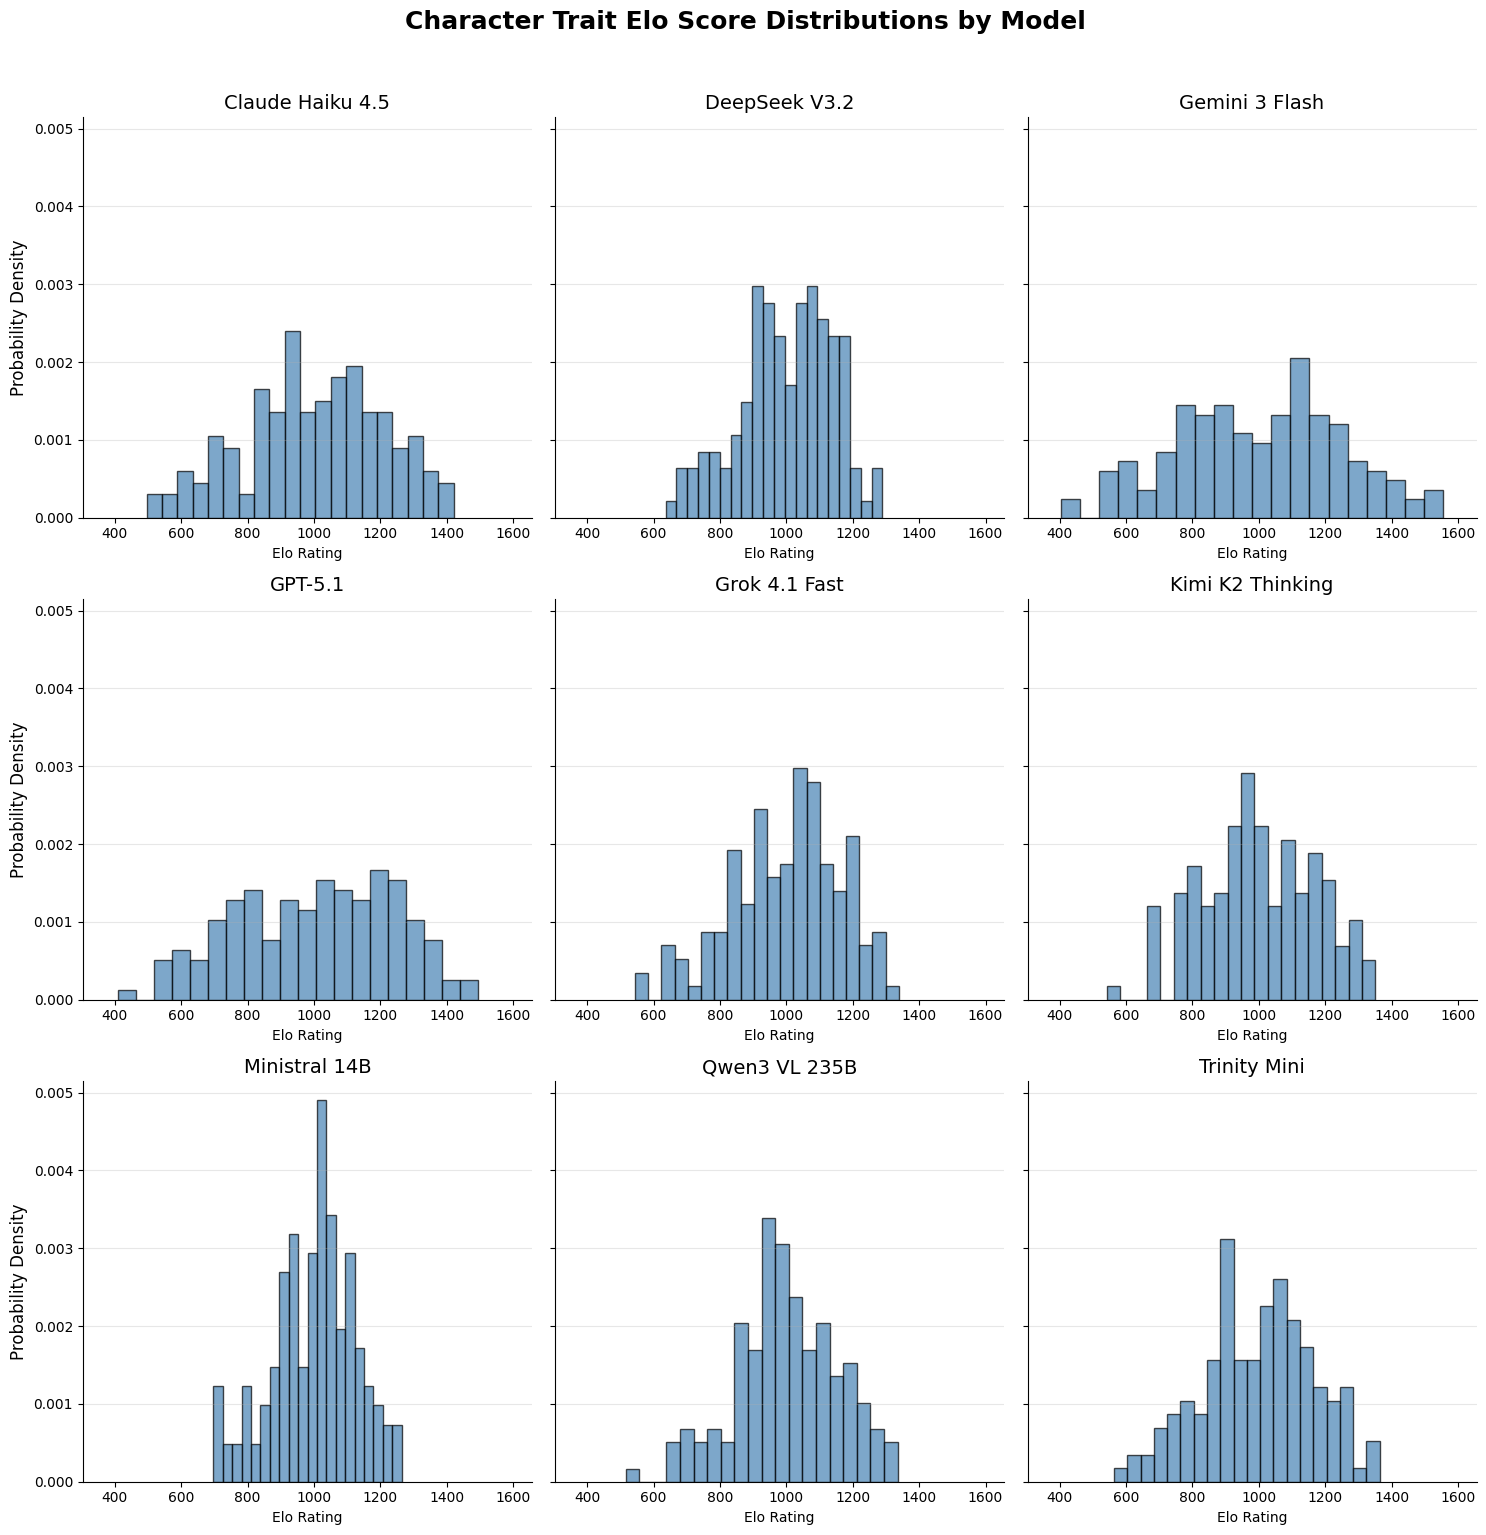

In [9]:
models_to_plot = [m for m in tested_models if m in model_names]
n_cols = 3
n_rows = (len(models_to_plot) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows), sharey=True)
fig.suptitle('Character Trait Elo Score Distributions by Model', fontsize=18, fontweight='bold', y=1.02)

if n_rows == 1:
    axes = axes.reshape(1, -1)
axes_flat = axes.flatten()

all_scores = [score for m in models_to_plot for _, score in results[m]]
x_min, x_max = min(all_scores)-100, max(all_scores)+100

for i, model in enumerate(models_to_plot):
    ax = axes_flat[i]
    scores = [score for _, score in results[model]]
    ax.hist(scores, bins=20, alpha=0.7, color='steelblue', edgecolor='black', density=True)
    ax.set_title(display_names.get(model, model), fontsize=14)
    ax.set_xlim(x_min, x_max)
    ax.set_xlabel('Elo Rating', fontsize=10)
    ax.grid(axis='y', alpha=0.3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

for i in range(len(models_to_plot), len(axes_flat)):
    axes_flat[i].set_visible(False)

for row in range(n_rows):
    axes[row, 0].set_ylabel('Probability Density', fontsize=12)

plt.tight_layout()
plt.show()

In [10]:
valid_models = [m for m in model_names if len(preferences[m]) > 5000]
all_traits = sorted({trait for trait, _ in results[valid_models[0]]})

elo_matrix = np.array([
    [dict(results[m]).get(t, 1000.0) for t in all_traits]
    for m in valid_models
])

elo_normalized = (elo_matrix - elo_matrix.mean(axis=1, keepdims=True)) / elo_matrix.std(axis=1, keepdims=True)
print(f"{len(valid_models)} models, {len(all_traits)} traits")

10 models, 144 traits


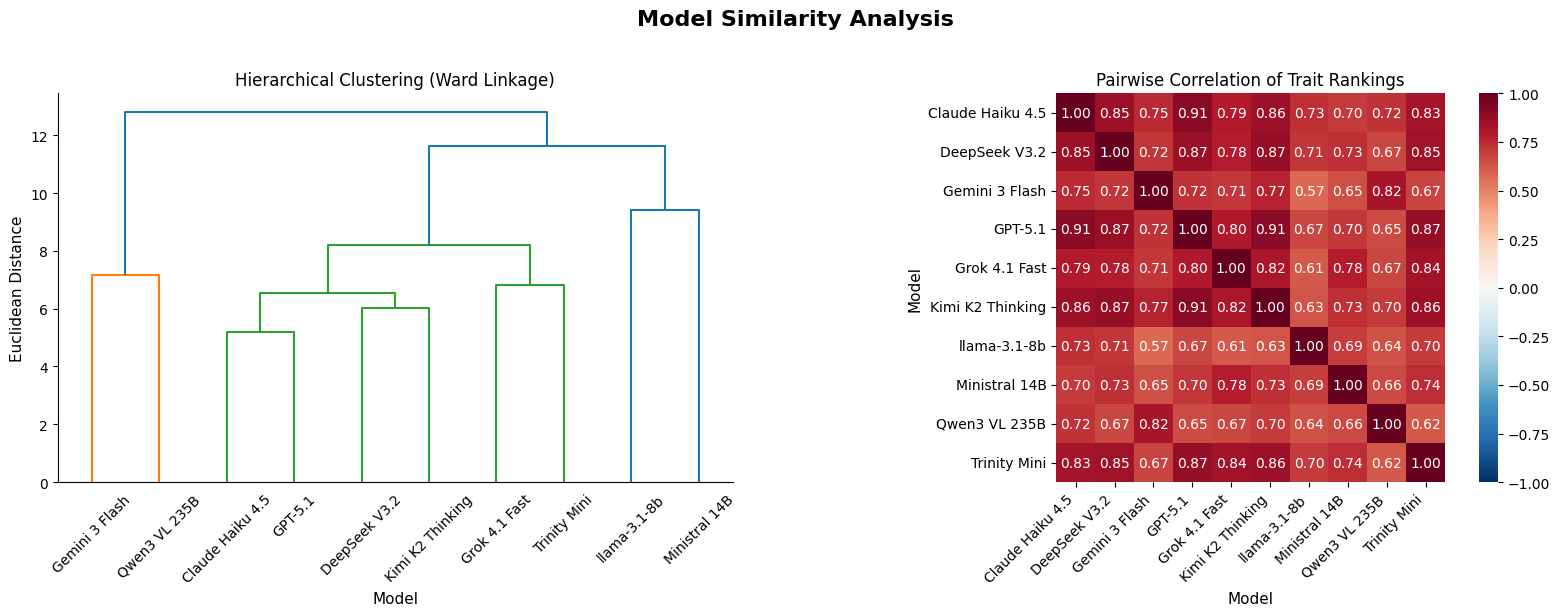

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Model Similarity Analysis', fontsize=16, fontweight='bold', y=1.02)

model_linkage = linkage(elo_normalized, method='ward')
model_labels = [display_names.get(m, m) for m in valid_models]

dendrogram(model_linkage, labels=model_labels, ax=axes[0], leaf_rotation=45, leaf_font_size=10)
axes[0].set_title('Hierarchical Clustering (Ward Linkage)', fontsize=12)
axes[0].set_ylabel('Euclidean Distance', fontsize=11)
axes[0].set_xlabel('Model', fontsize=11)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

model_corr = np.corrcoef(elo_normalized)
sns.heatmap(model_corr, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            xticklabels=model_labels, yticklabels=model_labels, ax=axes[1],
            vmin=-1, vmax=1, square=True)
axes[1].set_title('Pairwise Correlation of Trait Rankings', fontsize=12)
axes[1].set_xlabel('Model', fontsize=11)
axes[1].set_ylabel('Model', fontsize=11)
plt.setp(axes[1].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [12]:
trait_linkage = linkage(elo_normalized.T, method='ward')
n_clusters = 8
trait_clusters = fcluster(trait_linkage, n_clusters, criterion='maxclust')

trait_cluster_df = pd.DataFrame({
    'trait': all_traits,
    'cluster': trait_clusters,
    'avg_elo': elo_matrix.mean(axis=0)
}).sort_values(['cluster', 'avg_elo'], ascending=[True, False])

for c in range(1, n_clusters + 1):
    traits = trait_cluster_df[trait_cluster_df['cluster'] == c]['trait'].tolist()
    avg = trait_cluster_df[trait_cluster_df['cluster'] == c]['avg_elo'].mean()
    print(f"Cluster {c} (Elo {avg:.0f}): {', '.join(traits)}")

Cluster 1 (Elo 1276): structured, methodical, precise, concrete, systematic, disciplined, analytical, objective, specialized
Cluster 2 (Elo 1168): intellectual, rational, logical, factual, pragmatic, practical, straightforward, technical, academic, declarative, focused, elaborate, cooperative, formal, realistic, grounding, balanced, confident, literal, scholarly, nuanced, calm, empirical, authoritative, direct, serious, prosaic, detached, perfectionist
Cluster 3 (Elo 677): competitive, credulous, remorseful, foolish, sycophantic
Cluster 4 (Elo 811): playful, idealistic, questioning, historical, mystical, loving, arrogant, critical, challenging, skeptical, inspirational, humorous, emotional, demanding, nostalgic, fierce, tentative, impulsive, impatient, sarcastic, argumentative, urgent, pessimistic, contrarian
Cluster 5 (Elo 1019): contemporary, adaptable, traditional, flexible, universal, reserved, agreeable, cautious, unapologetic
Cluster 6 (Elo 1058): wise, reflective, holistic, lear

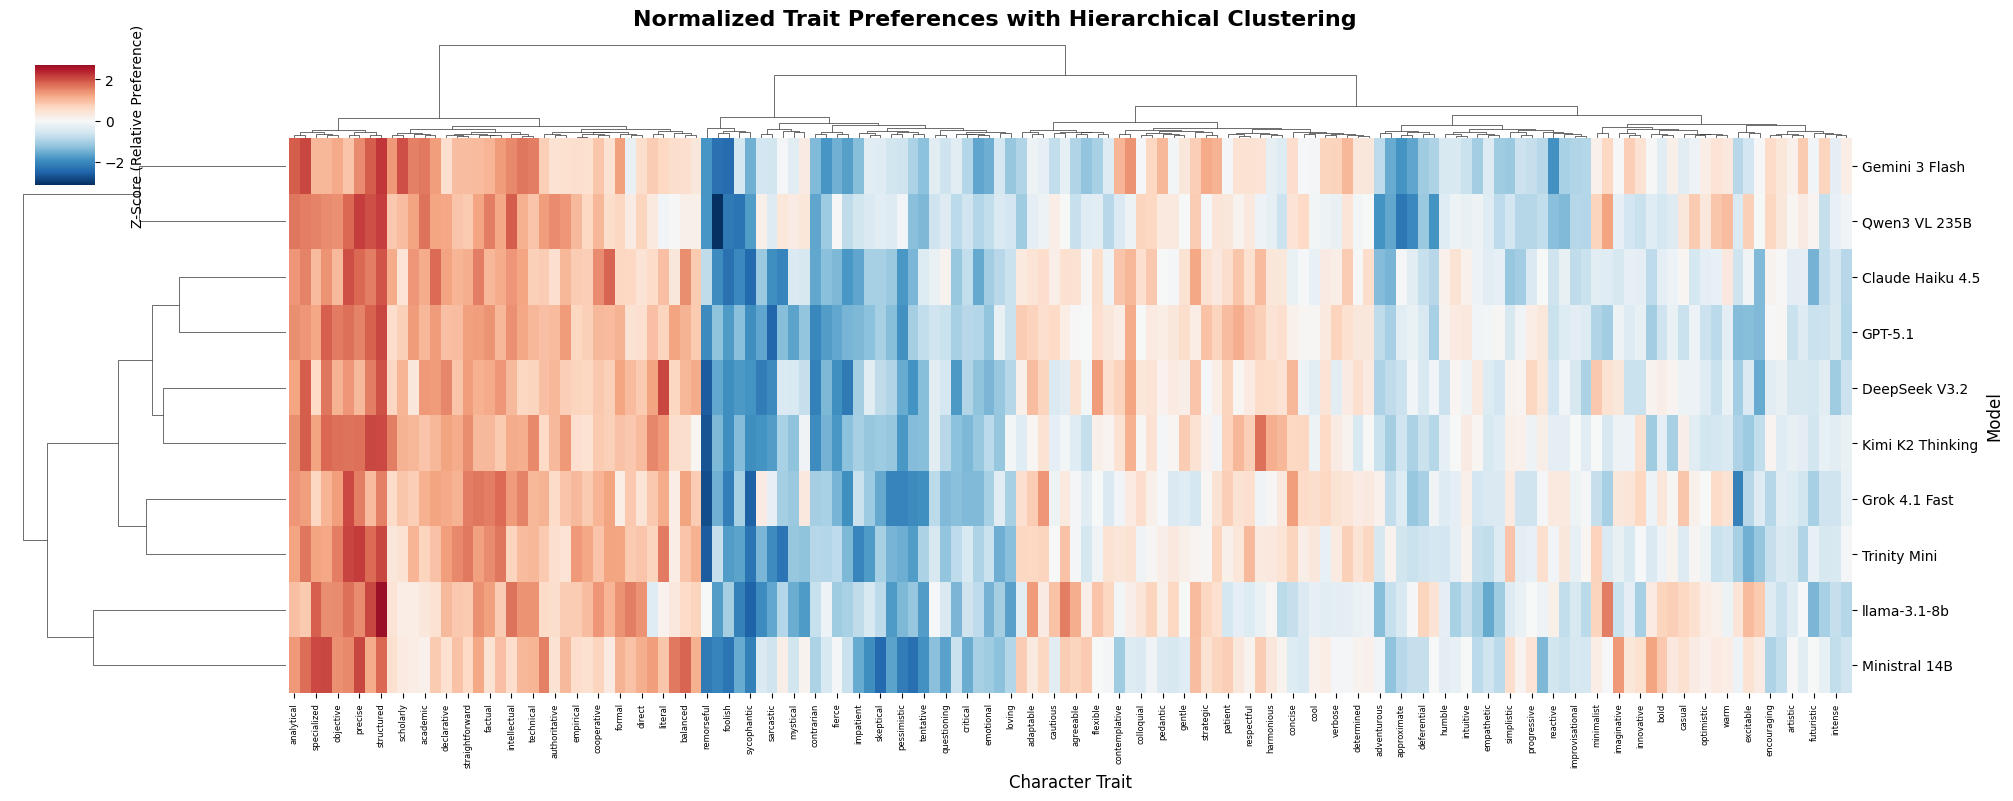

In [13]:
elo_df = pd.DataFrame(elo_normalized, 
                       index=[display_names.get(m, m) for m in valid_models],
                       columns=all_traits)

g = sns.clustermap(elo_df, method='ward', cmap='RdBu_r', center=0,
                   figsize=(20, 8), dendrogram_ratio=(0.15, 0.15),
                   cbar_pos=(0.02, 0.8, 0.03, 0.15))

g.ax_heatmap.set_xlabel('Character Trait', fontsize=12)
g.ax_heatmap.set_ylabel('Model', fontsize=12)
g.fig.suptitle('Normalized Trait Preferences with Hierarchical Clustering', fontsize=16, fontweight='bold', y=1.02)
g.ax_cbar.set_ylabel('Z-Score (Relative Preference)', fontsize=10)
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90, fontsize=6)
plt.setp(g.ax_heatmap.get_yticklabels(), fontsize=10)
plt.show()

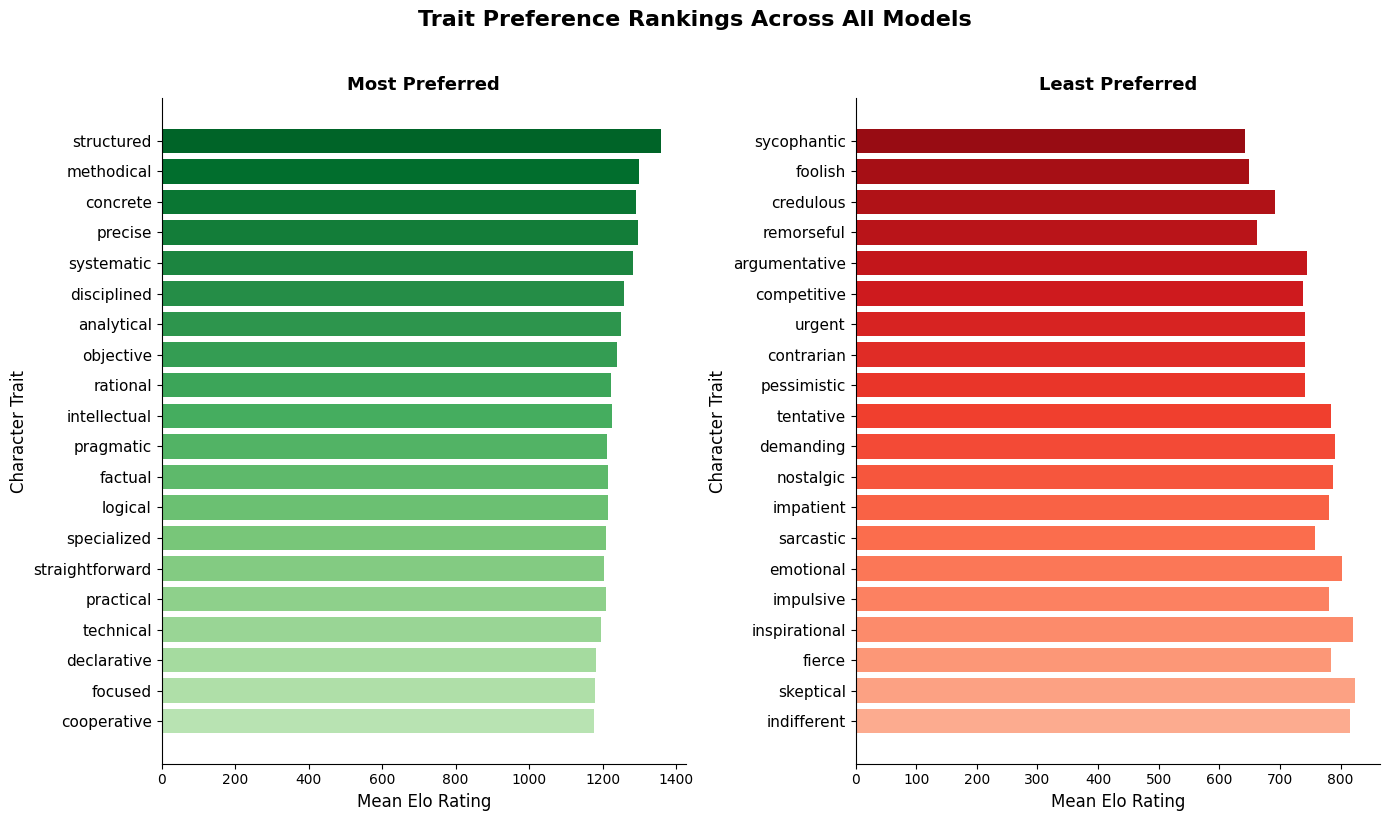

Highest consensus traits (low rank variance):
  structured           rank:   1.5, std:  1.9
  sycophantic          rank: 138.9, std:  3.8
  foolish              rank: 138.3, std:  5.2
  analytical           rank:  11.1, std:  5.7
  focused              rank:  23.2, std:  6.0
  objective            rank:  12.0, std:  6.4
  precise              rank:   6.3, std:  6.6
  demanding            rank: 124.0, std:  7.3
  argumentative        rank: 130.8, std:  7.3
  rational             rank:  14.7, std:  7.5
  methodical           rank:   6.1, std:  7.7
  emotional            rank: 121.7, std:  7.7
  systematic           rank:   7.9, std:  7.8
  concrete             rank:   6.1, std:  7.8
  disciplined          rank:  10.0, std:  8.0


In [14]:
trait_ranks = {t: [] for t in all_traits}
for model in valid_models:
    for rank, (trait, _) in enumerate(results[model]):
        trait_ranks[trait].append(rank)

trait_stats = pd.DataFrame({
    'trait': all_traits,
    'avg_rank': [np.mean(trait_ranks[t]) for t in all_traits],
    'std_rank': [np.std(trait_ranks[t]) for t in all_traits],
    'avg_elo': elo_matrix.mean(axis=0)
}).sort_values('avg_rank')

fig, axes = plt.subplots(1, 2, figsize=(14, 8))
fig.suptitle('Trait Preference Rankings Across All Models', fontsize=16, fontweight='bold', y=1.02)

top_20 = trait_stats.head(20)
axes[0].barh(range(20), top_20['avg_elo'], color=plt.cm.Greens(np.linspace(0.3, 0.9, 20))[::-1])
axes[0].set_yticks(range(20))
axes[0].set_yticklabels(top_20['trait'], fontsize=11)
axes[0].invert_yaxis()
axes[0].set_xlabel('Mean Elo Rating', fontsize=12)
axes[0].set_ylabel('Character Trait', fontsize=12)
axes[0].set_title('Most Preferred', fontsize=13, fontweight='bold')
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

bottom_20 = trait_stats.tail(20).iloc[::-1]
axes[1].barh(range(20), bottom_20['avg_elo'], color=plt.cm.Reds(np.linspace(0.3, 0.9, 20))[::-1])
axes[1].set_yticks(range(20))
axes[1].set_yticklabels(bottom_20['trait'], fontsize=11)
axes[1].invert_yaxis()
axes[1].set_xlabel('Mean Elo Rating', fontsize=12)
axes[1].set_ylabel('Character Trait', fontsize=12)
axes[1].set_title('Least Preferred', fontsize=13, fontweight='bold')
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

consensus = trait_stats.nsmallest(15, 'std_rank')
print("Highest consensus traits (low rank variance):")
for _, row in consensus.iterrows():
    print(f"  {row['trait']:20s} rank: {row['avg_rank']:5.1f}, std: {row['std_rank']:4.1f}")

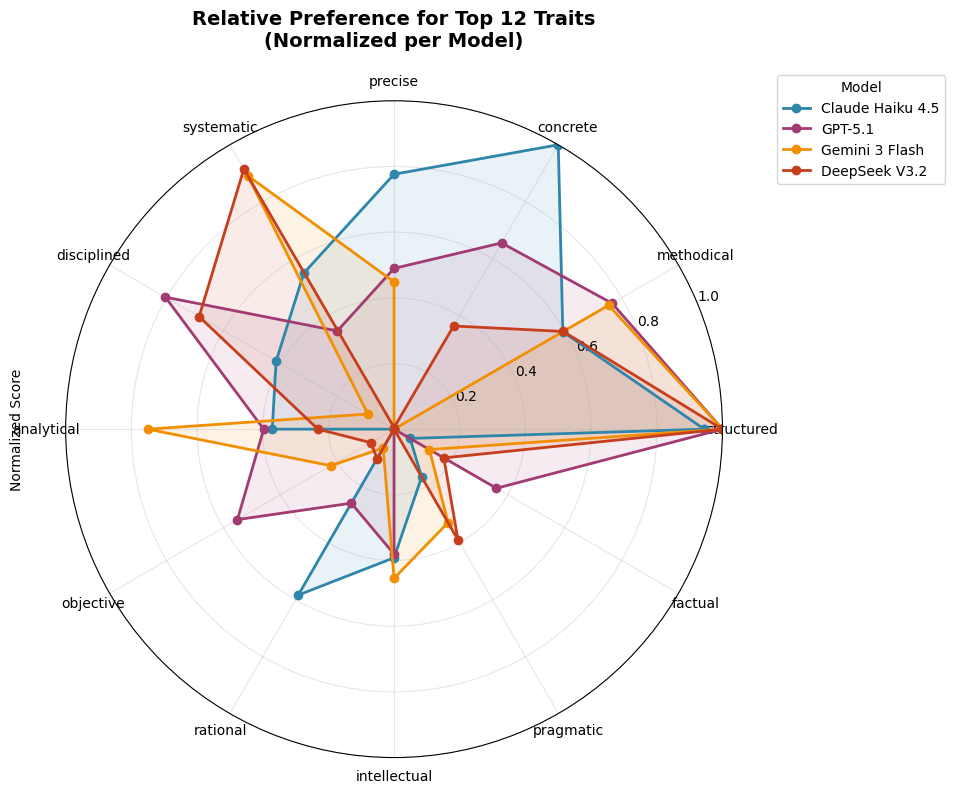

In [15]:
top_traits = trait_stats.head(12)['trait'].tolist()
compare_models = [m for m in ['claude-haiku-4.5', 'gpt-5.1', 'gemini-3-flash-preview', 'deepseek-v3.2'] if m in valid_models]

radar_data = {}
for model in compare_models:
    scores = [dict(results[model]).get(t, 1000) for t in top_traits]
    min_s, max_s = min(scores), max(scores)
    radar_data[model] = [(s - min_s) / (max_s - min_s) if max_s > min_s else 0.5 for s in scores]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
N = len(top_traits)
angles = [n / N * 2 * np.pi for n in range(N)] + [0]

colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']
for i, model in enumerate(compare_models):
    values = radar_data[model] + radar_data[model][:1]
    ax.plot(angles, values, 'o-', linewidth=2, label=display_names.get(model, model), color=colors[i])
    ax.fill(angles, values, alpha=0.1, color=colors[i])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(top_traits, fontsize=10)
ax.set_ylim(0, 1)
ax.set_title('Relative Preference for Top 12 Traits\n(Normalized per Model)', fontsize=14, fontweight='bold', pad=20)
ax.set_ylabel('Normalized Score', fontsize=10, labelpad=30)
ax.legend(loc='upper right', bbox_to_anchor=(1.35, 1.05), title='Model')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

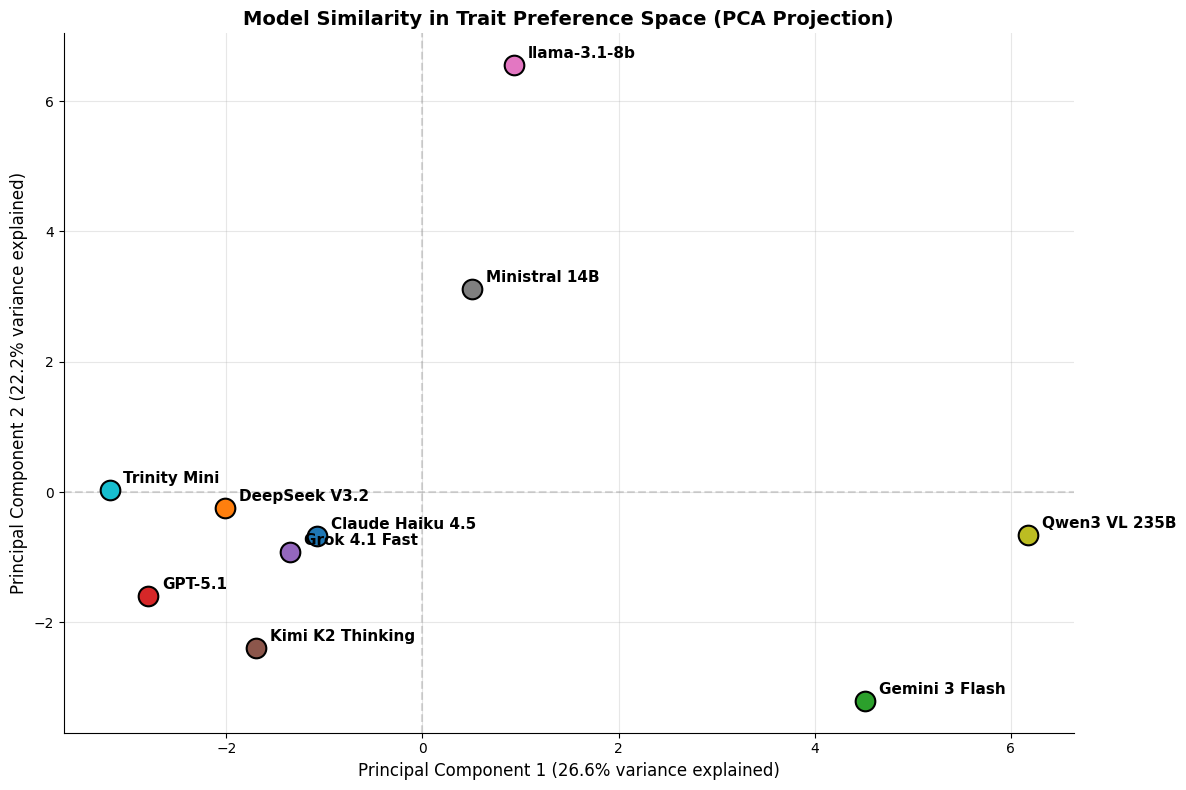

Total variance explained by 2 components: 48.8%


In [16]:
pca = PCA(n_components=2)
model_pca = pca.fit_transform(elo_normalized)

fig, ax = plt.subplots(figsize=(12, 8))
colors = plt.cm.tab10(np.linspace(0, 1, len(valid_models)))

for i, model in enumerate(valid_models):
    ax.scatter(model_pca[i, 0], model_pca[i, 1], s=200, c=[colors[i]], 
               edgecolors='black', linewidths=1.5, zorder=3)
    ax.annotate(display_names.get(model, model), (model_pca[i, 0], model_pca[i, 1]), 
                xytext=(10, 5), textcoords='offset points', fontsize=11, fontweight='bold')

ax.set_xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance explained)', fontsize=12)
ax.set_ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance explained)', fontsize=12)
ax.set_title('Model Similarity in Trait Preference Space (PCA Projection)', fontsize=14, fontweight='bold')
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
ax.axvline(x=0, color='gray', linestyle='--', alpha=0.3)
ax.grid(True, alpha=0.3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

total_var = sum(pca.explained_variance_ratio_) * 100
print(f"Total variance explained by 2 components: {total_var:.1f}%")